The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


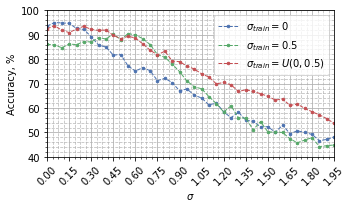

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 8
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = reversed([CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet][::2])
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.style.use('seaborn-deep')

load_dirs = [
    'without_noise/',
    #'small_noise/',
    #'middle_noise/',
    'big_noise/',
    'random_noise/'
]

train_sigma = [
    0,
    #0.05,
    #0.1,
    0.5,
    0.5
]


def parser(line_text: str) -> tuple:
    """
    Function parses text in form:
    ```v_name_1=v1:v_name_2:v2```
    and return (v1, v2)
    :param line_text:
    :return: (v1, v2)
    """
    line_text = line_text.split(":")
    v1 = line_text[0].split("=")[1]
    v2 = line_text[1].split("=")[1]
    return float(v1), float(v2)
%matplotlib inline
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(figsize=(5, 3))
#fig, ax = plt.subplots(figsize=(20, 10), tight_layout=True)
#sns.color_palette('deep')
# with open('accuracy_vs_noise.txt', 'r') as f:
lines = []
max_value = -100
for i, name in enumerate(load_dirs):
    
    x, y = [], []
    with open(
        os.path.join(name, 'accuracy_vs_noise_0.5_0.15.txt')
        ,
        "r",
    ) as f:
        line = f.readline()
        while line:
            t_x, t_y = parser(line)
            x.append(t_x)
            y.append(t_y)
            line = f.readline()
    line = plt.plot(x, 
                    y, 
                    '.', 
                    label=fr'$\sigma_{{train}}={train_sigma[i] if i != len(load_dirs) - 1 else "U(0, 0.5)"}$', 
                    linestyle='--', 
                    linewidth=1, 
                    markersize=5)
    lines.append(line)
    max_value = max(max_value, max(y))
#ax.add_patch(Rectangle((0, 0), 40, 30,)
plt.legend(ncol=1)
plt.xlabel('$\sigma$')
plt.ylabel('Accuracy, %')
plt.minorticks_on()
plt.grid()
plt.grid(which='minor', linestyle='--', alpha=.8)
plt.xticks(x[::3], rotation=45)
plt.xlim(x[0], x[-1])
plt.ylim(40, 100)
plt.tight_layout()
plt.savefig('/home/pugavko/Error_vs_noise.eps', format='eps')
plt.show()

In [175]:
! nvidia-smi

Sat May 14 12:06:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K40m          On   | 00000000:02:00.0 Off |                    0 |
| N/A   36C    P0    64W / 235W |   1966MiB / 11441MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40m          On   | 00000000:03:00.0 Off |                    0 |
| N/A   

In [3]:
from scipy.interpolate import interp1d

In [4]:
f_interp = interp1d(x , y, bounds_error=True)

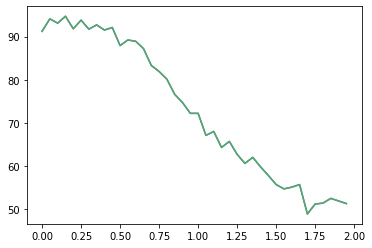

In [5]:
plt.plot(x, f_interp(x))
plt.plot(x, y)

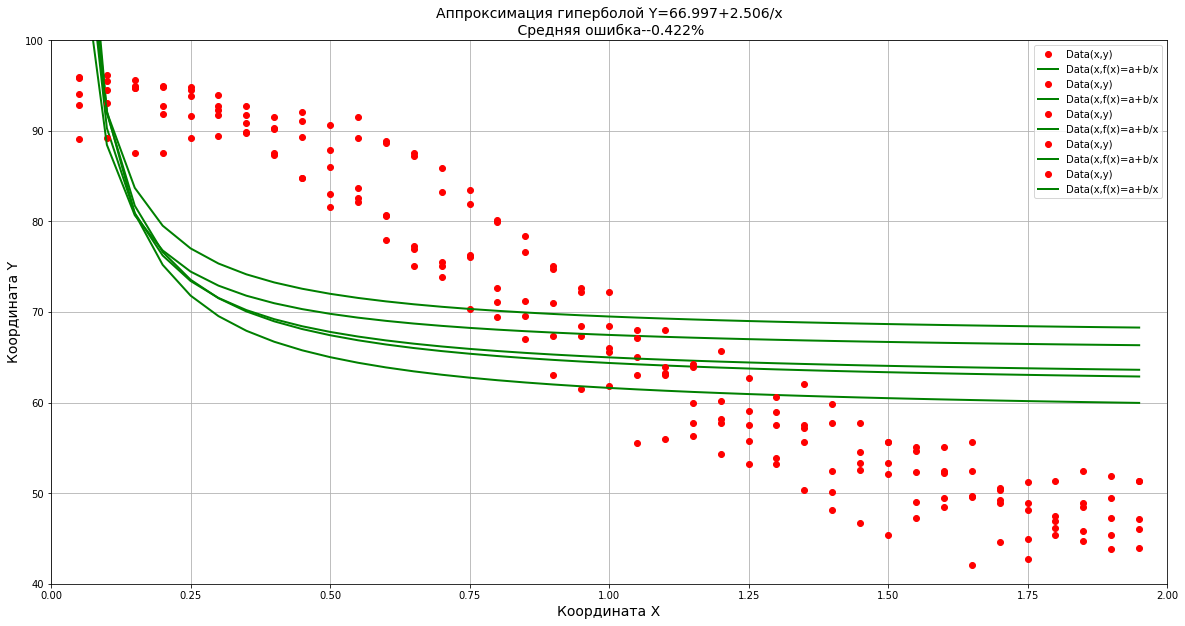

In [33]:
def pow_pol(x, fp):
    n = len(fp)
    result = 0
    for i in range(n):
        result += fp[i] * pow(x, n-i-1)
    return result
import scipy as sp
plt.figure(figsize=(20, 10))
def mnkGP(x,y, label):
    A=1
    p = -2# степень полинома
    d = 8
    fp, residuals, rank, sv, rcond = np.polyfit(x, y, d, full=True) # Модель
    f = sp.poly1d(fp) # аппроксимирующая функция
    print('Коэффициент -- a %s  '%round(fp[0],4))
    print('Коэффициент-- b %s  '%round(fp[1],4))
    print('Коэффициент -- c %s  '%round(fp[2],4))
    y1=[sum([fp[j] * pow(x[i], len(fp - j - 1)) for j in range(len(fp))]) for i in range(0,len(x))] # значения функции a*x**2+b*x+c
    #y1=[fp[0]*x[i]**4+fp[1]*x[i]**3+fp[2] * x[i] **2 + fp[1] * x[i] + fp[0] for i in range(0,len(x))] # значения функции a*x**2+b*x+c
    so=round(sum([abs(y[i]-y1[i]) for i in range(0,len(x))])/(len(x)*sum(y))*100,4) # средняя ошибка
    print('Average quadratic deviation '+str(so)) 
    fx = np.linspace(x[0], x[-1] + 1, len(x)) # можно установить вместо len(x) большее число для интерполяции
    
    l, = plt.plot(fx, f(fx), linewidth=1, label=label)
    plt.plot(x, y, '.', label='Original data', markersize=5, c=l.get_color())
    plt.grid(True)
    #plt.show()
def mnkGP(x,y, label): # функция которую можно использзовать в програме
    n=len(x) # количество элементов в списках
    s=sum(y) # сумма значений y
    s1=sum([1/x[i] for i in  range(0,n)]) #  сумма 1/x
    s2=sum([(1/x[i])**2 for i in  range(0,n)]) #  сумма (1/x)**2
    s3=sum([y[i]/x[i]  for i in range(0,n)])  # сумма y/x                   
    a= round((s*s2-s1*s3)/(n*s2-s1**2),3) # коэфициент а с тремя дробными цифрами
    b=round((n*s3-s1*s)/(n*s2-s1**2),3)# коэфициент b с тремя дробными цифрами
    s4=[a+b/x[i] for i in range(0,n)] # список значений гиперболической функции              
    so=round(sum([abs(y[i] -s4[i]) for i in range(0,n)])/(n*sum(y))*100,3)   # средняя ошибка аппроксимации
    plt.title('Аппроксимация гиперболой Y='+str(a)+'+'+str(b)+'/x\n Средняя ошибка--'+str(so)+'%',size=14)
    plt.xlabel('Координата X', size=14)
    plt.ylabel('Координата Y', size=14)
    plt.plot(x, y, color='r', linestyle=' ', marker='o', label='Data(x,y)')
    plt.plot(x, s4, color='g', linewidth=2, label='Data(x,f(x)=a+b/x')
    plt.legend(loc='best')
    plt.grid(True)
for i, name in enumerate(load_dirs):
    
    x, y = [], []
    with open(
        os.path.join(name, 'accuracy_vs_noise_0.15.txt')
        ,
        "r",
    ) as f:
        line = f.readline()
        while line:
            t_x, t_y = parser(line)
            x.append(t_x)
            y.append(t_y)
            line = f.readline()
    mnkGP(x[1:],y[1:], label=fr'$\sigma_{{train}}={train_sigma[i] if i != len(load_dirs) - 1 else "U(0, 0.5)"}$')
plt.xlim(0, 2)
plt.ylim(40, 100)
plt.legend()
plt.show()

(0.0, 1.5)

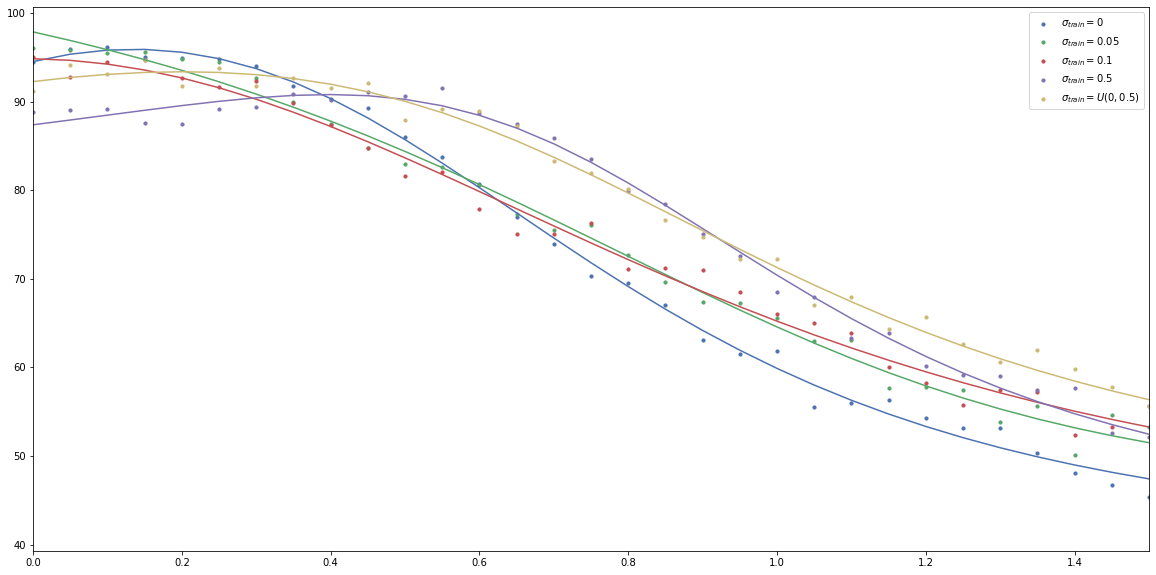

In [174]:
from scipy.optimize import curve_fit
plt.figure(figsize=(20, 10))
def func(t, A, h, b,m,r ,  T):
    return A * (h**2) / (4 * (x**2  - T)**2 + h**2) * np.exp(t * m)  + b


for i, name in enumerate(load_dirs):
    
    x, y = [], []
    with open(
        os.path.join(name, 'accuracy_vs_noise_0.15.txt')
        ,
        "r",
    ) as f:
        line = f.readline()
        while line:
            t_x, t_y = parser(line)
            x.append(t_x)
            y.append(t_y)
            line = f.readline()
    x = np.array(x)
    y = np.array(y)
    popt, pcov = curve_fit(func, x, y, (0.1, 0.01, 5, 5, 10, 1), maxfev=10**4, method='dogbox')    
    #A, h, T, b= popt

    #print('A={0}\nh={1}\nT={2}\nphi={3}'.format(*tuple(popt)))

    l, =plt.plot(x, func(x, *popt))
    plt.scatter(x, y, s=10, color=l.get_color(), label=fr'$\sigma_{{train}}={train_sigma[i] if i != len(load_dirs) - 1 else "U(0, 0.5)"}$')
plt.legend()
plt.xlim(0, 1.5)